# Classification and Logistic Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as op

In [2]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

In [3]:
def normalize(X):
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    X_norm = (X - X_mean) / X_std
    return X_norm

## Logistic regression

In [4]:
data = pd.read_csv('ex2/ex2data1.txt', names=['Test 1 Score', 'Test 2 Score', 'Outcome'])
data.head()

,Test 1 Score,Test 2 Score,Outcome
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


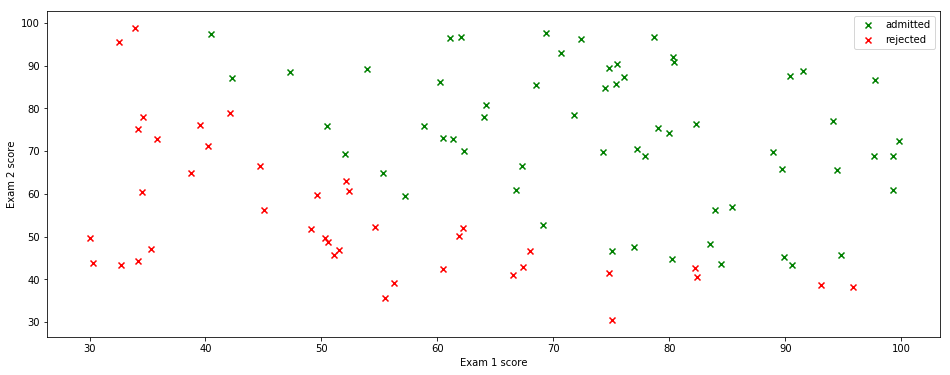

In [5]:
data = data.as_matrix()

admitted = data[data[:, 2] == 1]
rejected = data[data[:, 2] == 0]

fig, ax = plt.subplots()

ax.set_xlabel('Exam 1 score')
ax.set_ylabel('Exam 2 score')

ax.scatter(admitted[:, 0], admitted[:, 1], marker='x', label='admitted', color='green')
ax.scatter(rejected[:, 0], rejected[:, 1], marker='x', label='rejected', color='red')

plt.legend()

plt.show()

In [6]:
def sigmoid(z):
    return np.divide(1., 1 + np.exp(-z))

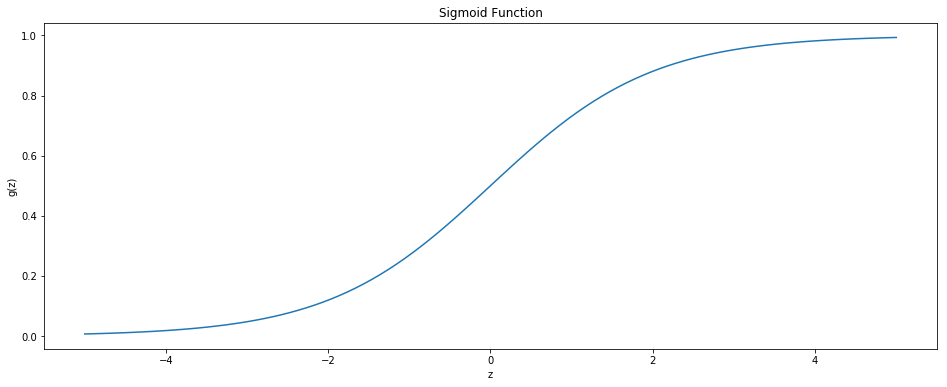

In [7]:
fig, ax = plt.subplots()

x = np.linspace(-5, 5, 100)
y = sigmoid(x)

ax.set_title('Sigmoid Function')
ax.set_ylabel('g(z)')
ax.set_xlabel('z')
ax.plot(x, y)

plt.show()

In [8]:
X = data[:, 0:2]
X = np.insert(normalize(X), 0, values=1, axis=1)

y = data[:, 2]
y = y[:, np.newaxis]

In [9]:
def logistic_cost(θ, X, y):
    m, n = X.shape
    if θ.ndim == 1:
        θ = θ[:, np.newaxis]
    h = sigmoid(np.dot(X, θ))
    log_likelihood = np.sum(np.dot(y.T, np.log(h)) +
                            np.dot((1 - y).T, np.log(1 - h)))
    cost = -1. / m * log_likelihood
    return cost

In [125]:
def logistic_gradient(θ, X, y):
    m, n = X.shape
    if θ.ndim == 1:
        θ = θ[:, np.newaxis]
    h = sigmoid(np.dot(X, θ))
    gradient = np.dot(X.T, h - y) / m
    return gradient.flatten()

In [126]:
initial_theta = np.zeros((X.shape[1], 1))
theta = op.fmin_bfgs(
        f=logistic_cost,          # objective to be minimized
        x0=initial_theta,         # initial guess
        fprime=logistic_gradient, # gradient of f
        args=(X, y)
    )

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20


In [127]:
print('Predicted parameters: ', theta)

Predicted parameters:  [ 1.71835728  3.99274735  3.7249355 ]


In [128]:
def predict(theta, X, y, threshold=0.5):
    m = y.shape[0]
    h = sigmoid(np.dot(X, theta))
    p = h > threshold
    return p, np.sum(p == y.flatten()) / m

In [133]:
prediction, accuracy = predict(theta, X, y)
print(f'Unregularized logistic regression predicts decision with accuracy: {int(accuracy * 100)}%')

Unregularized logistic regression predicts decision with accuracy: 89%


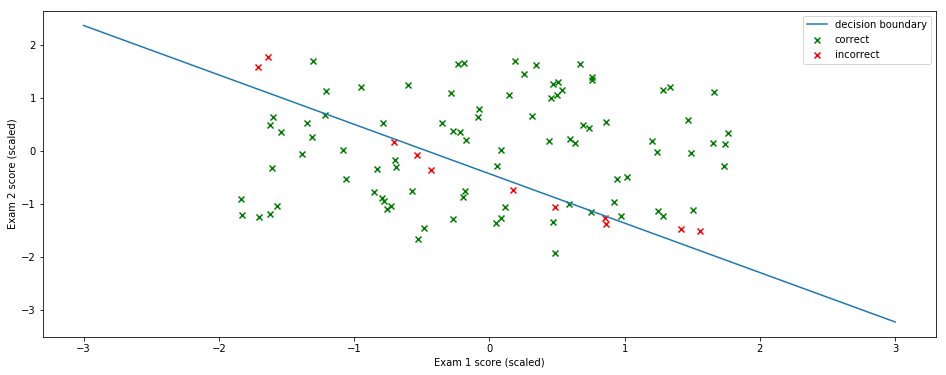

In [134]:
correct = X[prediction == data[:, 2]]
incorrect = X[prediction != data[:, 2]]

fig, ax = plt.subplots()

ax.set_xlabel('Exam 1 score (scaled)')
ax.set_ylabel('Exam 2 score (scaled)')

ax.scatter(correct[:, 1], correct[:, 2], marker='x', label='correct', color='green')
ax.scatter(incorrect[:, 1], incorrect[:, 2], marker='x', label='incorrect', color='red')

x = np.linspace(-3, 3, 100)
y = -(1 * theta[0] + x * theta[2]) / theta[1]
ax.plot(x, y, label='decision boundary')

plt.legend()

plt.show()

## Regularized logistic regression

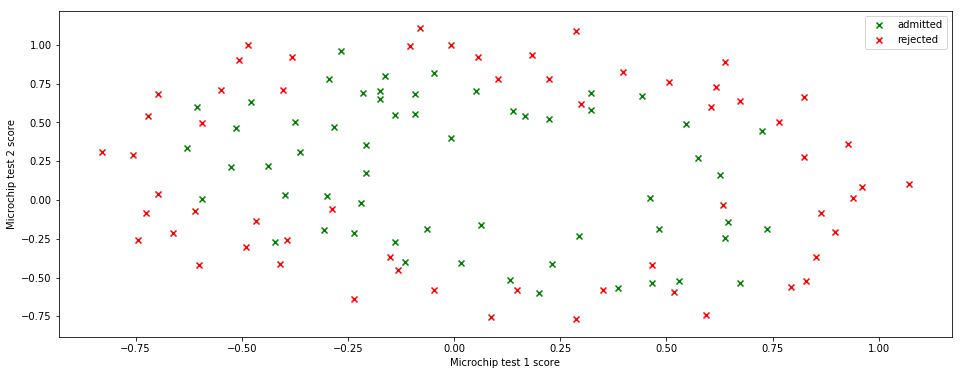

In [135]:
data = np.genfromtxt('ex2/ex2data2.txt', delimiter=',')

admitted = data[data[:, 2] == 1]
rejected = data[data[:, 2] == 0]

admitted_score1 = admitted[:, 0]
admitted_score2 = admitted[:, 1]
rejected_score1 = rejected[:, 0]
rejected_score2 = rejected[:, 1]

fig, ax = plt.subplots()

ax.set_xlabel('Microchip test 1 score')
ax.set_ylabel('Microchip test 2 score')

ax.scatter(admitted_score1, admitted_score2, marker='x', label='admitted', color='green')
ax.scatter(rejected_score1, rejected_score2, marker='x', label='rejected', color='red')

plt.legend()

plt.show()

In [137]:
def make_polynomial(x0, x1, degree):
    out = np.ones((x0.shape[0], 1))
    for i in range(1, degree + 1):
        for j in range(i + 1):
            new_col = x0**(i - j) * x1**j
            out = np.column_stack((out, new_col))
    return out

In [138]:
y = data[:, 2]
y = y[:, np.newaxis]

X = normalize(data[:, 0:2])
X = make_polynomial(X[:, 0], X[:, 1], 6)

In [65]:
def logistic_cost_reg(θ, X, y, λ):
    m, n = X.shape
    if θ.ndim == 1:
        θ = θ[:, np.newaxis]
    h = sigmoid(np.dot(X, θ))
    
    θ_reg = θ.copy()
    θ_reg[0] = 0
    penalty = λ / (2 * m) * np.sum(np.dot(θ_reg.T, θ_reg))

    log_likelihood = np.sum(np.dot(y.T, np.log(h)) + np.dot((1 - y).T, np.log(1 - h)))
    cost = -1. / m * log_likelihood + penalty
    return cost

In [72]:
def logistic_gradient_reg(θ, X, y, λ):
    m, n = X.shape
    if θ.ndim == 1:
        θ = θ[:, np.newaxis]
    h = sigmoid(np.dot(X, θ))    

    θ_reg = θ.copy()
    θ_reg[0] = 0

    penalty = λ / m * θ_reg
    grad = np.dot(X.T, h - y) / m + penalty
    return grad.flatten()

In [73]:
def solve_logistic_reg(X, y, reg_parameter):
    initial_theta = np.zeros((X.shape[1], 1))
    theta_reg = op.fmin_bfgs(
            f = logistic_cost_reg, 
            x0 = initial_theta,
            fprime = logistic_gradient_reg,
            args = (X, y, reg_parameter)
        )
    return theta_reg    

Optimization terminated successfully.
         Current function value: 0.291455
         Iterations: 117
         Function evaluations: 119
         Gradient evaluations: 119
Optimization terminated successfully.
         Current function value: 0.320700
         Iterations: 66
         Function evaluations: 68
         Gradient evaluations: 68
Optimization terminated successfully.
         Current function value: 0.582814
         Iterations: 24
         Function evaluations: 33
         Gradient evaluations: 33


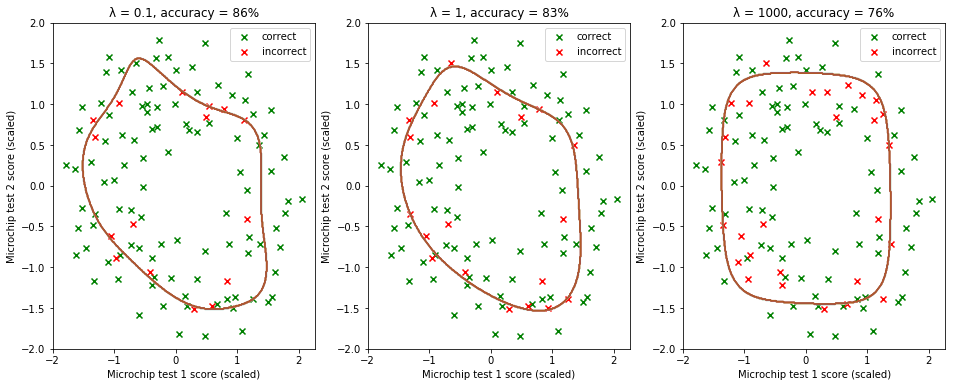

In [78]:
fig, axs = plt.subplots(1, 3)
axs = axs.flatten()
reg_parameters = [0.1, 1, 1000]

for i in range(len(axs)):
    ax = axs[i]
    reg_parameter = reg_parameters[i]
    theta_reg = solve_logistic_reg(X, y, reg_parameter)
    prediction, accuracy = predict(theta_reg, X, y)

    correct = X[prediction == data[:, 2]]
    incorrect = X[prediction != data[:, 2]]

    ax.set_xlabel('Microchip test 1 score (scaled)')
    ax.set_ylabel('Microchip test 2 score (scaled)')

    ax.scatter(correct[:, 1], correct[:, 2], marker='x', label='correct', color='green')
    ax.scatter(incorrect[:, 1], incorrect[:, 2], marker='x', label='incorrect', color='red')

    # plot decision boundary
    x_b, y_b = np.meshgrid(np.linspace( -2, 2, 400), np.linspace( -2, 2, 400))
    z_b = np.dot(make_polynomial(x_b.ravel(), y_b.ravel(), 6), theta_reg).reshape(x_b.shape)
    z_b = sigmoid(z_b)
    z_b = np.array(z_b > 0.5, dtype=int)
    ax.contour(x_b, y_b, z_b, cmap=plt.cm.Paired)

    ax.legend()
    ax.set_title(f'λ = {reg_parameter}, accuracy = {int(accuracy * 100)}%')

plt.show()